# Loading and preprocessing

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
dataset = pd.read_csv('../data/dataset.csv')
print(dataset.head())

   schoolid  Z         Y  S3  C1  C2  C3  XC        X1        X2        X3  \
0        76  1  0.081602   6   4   2   1   4  0.334544  0.648586 -1.310927   
1        76  1 -0.385869   4  12   2   1   4  0.334544  0.648586 -1.310927   
2        76  1  0.398184   6   4   2   0   4  0.334544  0.648586 -1.310927   
3        76  1 -0.175037   6   4   2   0   4  0.334544  0.648586 -1.310927   
4        76  1  0.884583   6   4   1   0   4  0.334544  0.648586 -1.310927   

         X4        X5  
0  0.224077 -0.426757  
1  0.224077 -0.426757  
2  0.224077 -0.426757  
3  0.224077 -0.426757  
4  0.224077 -0.426757  


In [3]:
# Columns are renamed to more descriptive names for clarity.
data = dataset.rename(columns={
        'Y': 'StudentAchievementScore',
        'Z': 'GrowthMindsetIntervention',
        'S3': 'FutureSuccessExpectations',
        'C1': 'StudentRaceEthnicity',
        'C2': 'StudentGender',
        'C3': 'FirstGenCollegeStatus',
        'XC': 'SchoolUrbanicity',
        'X1': 'PreInterventionFixedMindset',
        'X2': 'SchoolAchievementLevel',
        'X3': 'SchoolMinorityComposition',
        'X4': 'PovertyConcentration',
        'X5': 'TotalStudentPopulation'
    })

In [4]:
# Define covariates, treatment, and outcome
covariate_cols = ['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']
treatment_col = 'Z'
outcome_col = 'Y'

# Split train and test data

In [17]:
# Split the data into training and testing sets
# stratification to ensure that the proportion of treated and control individuals in Z is maintained in both training and test sets
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42, stratify=dataset[treatment_col])


# Standardizing the Covariates


Standardizing the Covariates
The covariates (independent variables) are standardized to ensure that they are on a similar scale. Standardization is a preprocessing technique where each feature is transformed to have a mean of 0 and a standard deviation of 1. This is particularly important because covariates can vary widely in their ranges and units; some may span from 0 to 1000, while others might only vary between 0 and 1. If these variables are not standardized, those with larger ranges could disproportionately influence the model, leading to biased results.

To standardize the data, the code uses StandardScaler from Scikit-Learn’s preprocessing module. The scaler first calculates the mean and standard deviation of each covariate using the training data. It then applies these statistics to transform both the training and testing data. The training data is transformed using fit_transform, which both calculates the necessary statistics and applies the transformation. The testing data is transformed using transform, which ensures that the same scaling applied to the training data is also applied to the testing data, preserving consistency.

In [18]:
scaler = StandardScaler()

# Using .loc[] to ensure you're explicitly modifying the DataFrame
train_data.loc[:, covariate_cols] = scaler.fit_transform(train_data.loc[:, covariate_cols])
test_data.loc[:, covariate_cols] = scaler.transform(test_data.loc[:, covariate_cols])

# parameter grid for each model

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

In [20]:
# Define the parameter grid for each model
param_grids = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 100)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd']
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.1, 0.2, 0.5]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

# Grid Search CV

In [21]:
import numpy as np
def grid_search_cv(data, treatment_col, outcome_col, covariate_cols, model, params, meta_learner):
    """
    Perform GridSearchCV for hyperparameter tuning and return the best model.
    """
    X = data[covariate_cols + [treatment_col]]
    y = data[outcome_col]

    scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scoring_metrics, refit='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)

    # Get the best parameters and best model
    best_model = grid_search.best_estimator_  # The best model found
    best_params = grid_search.best_params_    # The parameters that led to the best model
    best_score_mse = -grid_search.best_score_  # Convert back to positive MSE
    
    # Get the best MAE and R²
    best_mae = -grid_search.cv_results_['mean_test_neg_mean_absolute_error'][grid_search.best_index_]
    best_r2 = grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]
    
    # Print the best parameters and corresponding metrics
    print(f"Best parameters for {meta_learner} with {model.__class__.__name__}: {best_params}")
    print(f"Best MSE: {best_score_mse:.4f}, Best MAE: {best_mae:.4f}, Best R²: {best_r2:.4f}")
    
    # Return the best model (estimator) and the evaluation metrics
    return best_model, best_score_mse, best_mae, best_r2


# Meta-Learners

## s-Learner

In [22]:
def s_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an S-learner model to estimate CATE.
    """
    X = data[covariate_cols + [treatment_col]]
    y = data[outcome_col]
    model.fit(X, y)
    return model

In [23]:
def t_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train a T-learner model to estimate CATE.
    """
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]
    X_control = control[covariate_cols]
    y_control = control[outcome_col]
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)
    return model_treated, model_control

In [24]:
def x_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an X-learner model to estimate CATE.
    """
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]
    X_control = control[covariate_cols]
    y_control = control[outcome_col]
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)
    treated_outcome = model_control.predict(X_treated)
    control_outcome = model_treated.predict(X_control)
    treatment_effect_treated = y_treated - treated_outcome
    treatment_effect_control = control_outcome - y_control
    model_treatment_effect_treated = model.fit(X_treated, treatment_effect_treated)
    model_treatment_effect_control = model.fit(X_control, treatment_effect_control)
    return model_treatment_effect_treated, model_treatment_effect_control

In [25]:
from sklearn.linear_model import  LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

def r_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an improved R-learner model to estimate CATE with robust residual handling and regularization.
    
    Parameters:
    - data: DataFrame containing the data
    - treatment_col: Column name for the treatment variable
    - outcome_col: Column name for the outcome variable
    - covariate_cols: List of column names for covariates
    - model: The base model to be used for predicting outcomes and treatment
    - regularization: Type of regularization to use ('ridge' or 'lasso')
    
    Returns:
    - tau_model: The trained model for estimating treatment effects
    - y_model: The outcome model
    - t_model: The treatment model
    - y_residual: Residuals of the outcome model
    - t_residual: Residuals of the treatment model
    """
    X = data[covariate_cols]
    T = data[treatment_col]
    y = data[outcome_col]

    # Fit outcome model
    y_model = cross_val_predict(model, X, y, cv=5)
    
    # Fit treatment model
    t_model = cross_val_predict(model, X, T, cv=5)
    
    # Calculate residuals
    y_residual = y - y_model
    t_residual = T - t_model
    
    # Regularization of residuals
    t_residual_clipped = np.clip(t_residual, a_min=0.01, a_max=None)
    y_residual = (y_residual - np.mean(y_residual)) / np.std(y_residual)
    t_residual_clipped = (t_residual_clipped - np.mean(t_residual_clipped)) / np.std(t_residual_clipped)
    
    # Add a small constant to prevent division by zero
    epsilon = 1e-3 * np.std(t_residual)
    t_residual_regularized = t_residual_clipped + epsilon
    
#     # Use RidgeCV or LassoCV for additional regularization in the final model
#     regularization = 'ridge'
#     tau_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
    regularization = 'lasso'
    tau_model = LassoCV(alphas=[0.1, 1.0, 10.0])
    
    
    # Fit the treatment effect model
    tau_model.fit(X, y_residual / t_residual_regularized)
    
    return tau_model, y_model, t_model, y_residual, t_residual


# Evaluate model

In [26]:
from sklearn.utils import resample

def evaluate_emse(data, treatment_col, outcome_col, covariate_cols, model, meta_learner, n_bootstraps=100, n_splits=5):
    """
    Evaluate the model using bootstrapping to approximate the EMSE.
    
    n_bootstraps: Number of bootstrap samples to generate
    n_splits: Number of folds in cross-validation (for the inner MSE calculation)
    """
    mse_list = []
    
    for _ in range(n_bootstraps):
        # Create a bootstrapped sample
        bootstrapped_data = resample(data, replace=True)
        
        # Evaluate the model using cross-validation on the bootstrapped sample
        X = bootstrapped_data[covariate_cols + [treatment_col]]
        y = bootstrapped_data[outcome_col]
        
        if meta_learner == 's':
            predictions = model.predict(X)
        elif meta_learner == 't':
            treated, control = model
            predictions_treated = treated.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 1][covariate_cols])
            predictions_control = control.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 0][covariate_cols])
            predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
        elif meta_learner == 'x':
            treated, control = model
            predictions_treated = treated.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 1][covariate_cols])
            predictions_control = control.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 0][covariate_cols])
            predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
        elif meta_learner == 'r':
            tau_model, _, _, _, _ = model
            predictions = tau_model.predict(bootstrapped_data[covariate_cols])
        
        mse = mean_squared_error(y, predictions)
        mse_list.append(mse)
    
    # Calculate the EMSE as the mean of the MSEs from the bootstrapped samples
    emse = np.mean(mse_list)
    return emse


# Find Baset parameters for each model

## S-Learner

In [27]:
from sklearn.metrics import mean_squared_error
emse_results = []

for model_name, config in param_grids.items():
    best_model, best_mse, best_mae, best_r2  = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'S-Learner')
    s_model = s_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_s = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, s_model, 's')
    emse_results.append({'Meta-Learner': 'S-Learner', 'Model': model_name, 'EMSE': emse_s,'MSE': best_mse, 'MAE': best_mae, 'R²': best_r2})

    best_model, best_mse, best_mae, best_r2  = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'T-Learner')
    t_model_treated, t_model_control = t_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_t = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, (t_model_treated, t_model_control), 't')
    emse_results.append({'Meta-Learner': 'T-Learner', 'Model': model_name, 'EMSE': emse_t,'MSE': best_mse, 'MAE': best_mae, 'R²': best_r2})

    best_model, best_mse, best_mae, best_r2  = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'X-Learner')
    x_model_treated, x_model_control = x_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_x = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, (x_model_treated, x_model_control), 'x')
    emse_results.append({'Meta-Learner': 'X-Learner', 'Model': model_name, 'EMSE': emse_x,'MSE': best_mse, 'MAE': best_mae, 'R²': best_r2})

    best_model, best_mse, best_mae, best_r2  = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'R-Learner')
    r_model, y_model, t_model, y_residual, t_residual = r_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_r = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, (r_model, y_model, t_model, y_residual, t_residual), 'r')
    emse_results.append({'Meta-Learner': 'R-Learner', 'Model': model_name, 'EMSE': emse_r,'MSE': best_mse, 'MAE': best_mae, 'R²': best_r2})

emse_df = pd.DataFrame(emse_results)


Best parameters for S-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for T-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for X-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for R-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for S-Learner with GradientBoostingRegressor: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best parameters for T-Learner with GradientBoostingRegressor: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best parameters for X-Learner with GradientBoostingRegressor: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best parameters for R-Learner with GradientBoostingRegressor: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best parameters for S-Le

## Plot the EMSE Results


   Meta-Learner             Model      EMSE
0     S-Learner      RandomForest  0.286303
1     T-Learner      RandomForest  0.560633
2     X-Learner      RandomForest  0.436906
3     R-Learner      RandomForest  0.528770
4     S-Learner  GradientBoosting  0.267615
5     T-Learner  GradientBoosting  0.555601
6     X-Learner  GradientBoosting  0.435517
7     R-Learner  GradientBoosting  0.541127
8     S-Learner     NeuralNetwork  0.283755
9     T-Learner     NeuralNetwork  0.551785
10    X-Learner     NeuralNetwork  0.437851
11    R-Learner     NeuralNetwork  0.524845
12    S-Learner             Ridge  0.304917
13    T-Learner             Ridge  0.513601
14    X-Learner             Ridge  0.431587
15    R-Learner             Ridge  0.519384
16    S-Learner             Lasso  0.353538
17    T-Learner             Lasso  0.456848
18    X-Learner             Lasso  0.433135
19    R-Learner             Lasso  0.529069
20    S-Learner               SVR  0.281887
21    T-Learner               SV

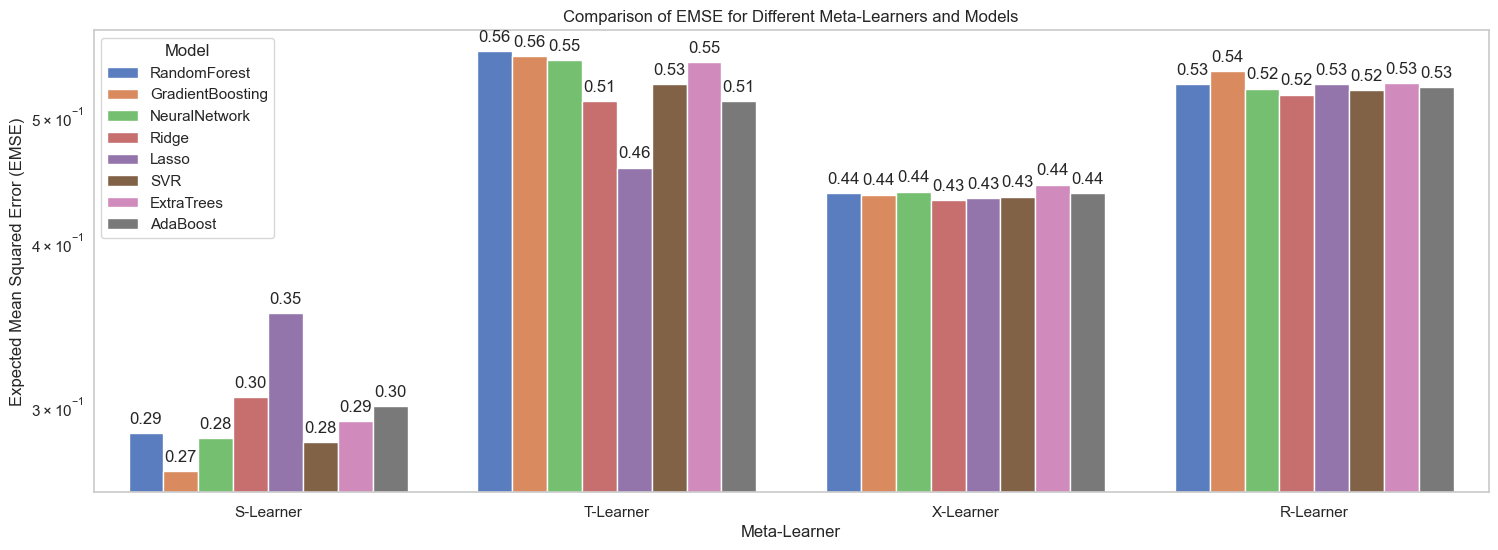

In [16]:
print(emse_df)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(18, 6))
ax = sns.barplot(x='Meta-Learner', y='EMSE', hue='Model', data=emse_df, palette="muted")
plt.title('Comparison of EMSE for Different Meta-Learners and Models')
plt.xlabel('Meta-Learner')
plt.ylabel('Expected Mean Squared Error (EMSE)')
plt.legend(title='Model')
plt.yscale('log')

# Adding the numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()